In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sb
import os
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip
import tensorflow.keras.layers as tfl
from tensorflow.keras.preprocessing import image_dataset_from_directory

import glob as gb
import cv2
import keras

In [2]:
df = pd.read_csv('../input/paddy-doctor/paddy-disease-classification/train.csv')

In [3]:
df["label"].value_counts()

normal                      1764
blast                       1738
hispa                       1594
dead_heart                  1442
tungro                      1088
brown_spot                   965
downy_mildew                 620
bacterial_leaf_blight        479
bacterial_leaf_streak        380
bacterial_panicle_blight     337
Name: label, dtype: int64

In [4]:
code = {'normal':0 ,'blast':1,'hispa':2,'dead_heart':3,'tungro':4,'brown_spot':5 , 'downy_mildew':6 ,'bacterial_leaf_blight':7 , 'bacterial_leaf_streak':8 ,'bacterial_panicle_blight':9  }

def getcode(n) : 
    for x , y in code.items() : 
        if n == y : 
            return x

In [5]:
train_path = '../input/paddy-doctor/paddy-disease-classification/train_images/'
test_path = '../input/paddy-doctor/paddy-disease-classification/test_images/'

In [6]:
s = 150
X = []
y = []
for folder in  os.listdir(train_path) : 
    files = gb.glob(pathname= str( train_path  + folder + '/*.jpg'))
    for file in files: 
        image = cv2.imread(file)
        image_array = cv2.resize(image , (s,s))
        X.append(list(image_array))
        y.append(code[folder])

print(f'we have {len(X)} items in X ')

we have 10407 items in X 


In [7]:
X = np.array(X)
y = np.array(y)

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2,  shuffle=True, random_state=42)

In [9]:
del X
del y

In [10]:
from sklearn.model_selection import train_test_split
X_test, X_validate, y_test, y_validate = train_test_split(X_valid, y_valid, test_size=0.5,  shuffle=True, random_state=42)

In [11]:
del X_valid
del y_valid

In [12]:
from keras.models import Sequential
from keras.layers import Conv2D, Dense, BatchNormalization, Flatten,Dropout
import tensorflow 

In [15]:

from tensorflow.keras.applications import ResNet50

model= Sequential()
model.add(ResNet50(include_top=False,pooling='avg', weights = 'imagenet'))
model.add(Dense(512, activation='relu'))
model.add(Dropout(.3))
model.add(Dense(10, activation='softmax'))

model.layers[0].trainable = False

model.compile(loss = 'sparse_categorical_crossentropy', 
               optimizer = 'adam',
               metrics = ['acc'])



model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dense_2 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5130      
Total params: 24,641,930
Trainable params: 1,054,218
Non-trainable params: 23,587,712
_________________________________________________________________


In [16]:
history = model.fit(X_train, y_train, batch_size=32,
         validation_data=(X_validate, y_validate),epochs=40)

Epoch 1/40


2022-11-22 17:00:00.508831: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


261/261 [==============================] - 19s 41ms/step - loss: 1.4783 - acc: 0.5086 - val_loss: 1.0025 - val_acc: 0.6888
Epoch 2/40
261/261 [==============================] - 9s 36ms/step - loss: 0.9247 - acc: 0.6907 - val_loss: 0.8135 - val_acc: 0.7502
Epoch 3/40
261/261 [==============================] - 9s 36ms/step - loss: 0.7186 - acc: 0.7631 - val_loss: 0.7243 - val_acc: 0.7627
Epoch 4/40
261/261 [==============================] - 9s 36ms/step - loss: 0.5707 - acc: 0.8135 - val_loss: 0.6984 - val_acc: 0.7867
Epoch 5/40
261/261 [==============================] - 10s 37ms/step - loss: 0.4583 - acc: 0.8535 - val_loss: 0.5743 - val_acc: 0.8194
Epoch 6/40
261/261 [==============================] - 10s 38ms/step - loss: 0.3957 - acc: 0.8724 - val_loss: 0.5108 - val_acc: 0.8473
Epoch 7/40
261/261 [==============================] - 9s 36ms/step - loss: 0.3373 - acc: 0.8876 - val_loss: 0.4500 - val_acc: 0.8646
Epoch 8/40
261/261 [==============================] - 9s 36ms/step - loss: 0.

In [17]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test, batch_size=32)
print("test loss, test acc:", results)


Evaluate on test data
33/33 [==============================] - 1s 31ms/step - loss: 0.4350 - acc: 0.9107
test loss, test acc: [0.43502357602119446, 0.910662829875946]


Text(0, 0.5, 'Loss')

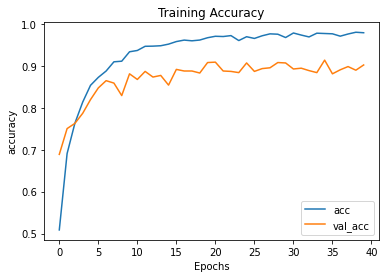

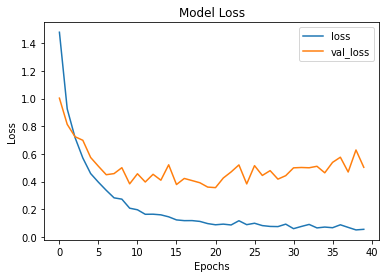

In [18]:
# converting hsitory to dataframe
pd.DataFrame(history.history)

pd.DataFrame(history.history)[['acc', 'val_acc']].plot()
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')

pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [19]:
y_pred = model.predict(X_test)

In [20]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test, np.argmax(y_pred, axis=1) ) )

              precision    recall  f1-score   support

           0       0.85      0.96      0.90       168
           1       0.92      0.92      0.92       172
           2       0.92      0.89      0.90       158
           3       0.93      0.97      0.95       139
           4       0.89      0.87      0.88       109
           5       0.94      0.91      0.93       117
           6       0.88      0.86      0.87        58
           7       0.96      0.85      0.90        52
           8       0.97      0.90      0.94        40
           9       0.95      0.75      0.84        28

    accuracy                           0.91      1041
   macro avg       0.92      0.89      0.90      1041
weighted avg       0.91      0.91      0.91      1041



In [21]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



Confusion matrix, without normalization


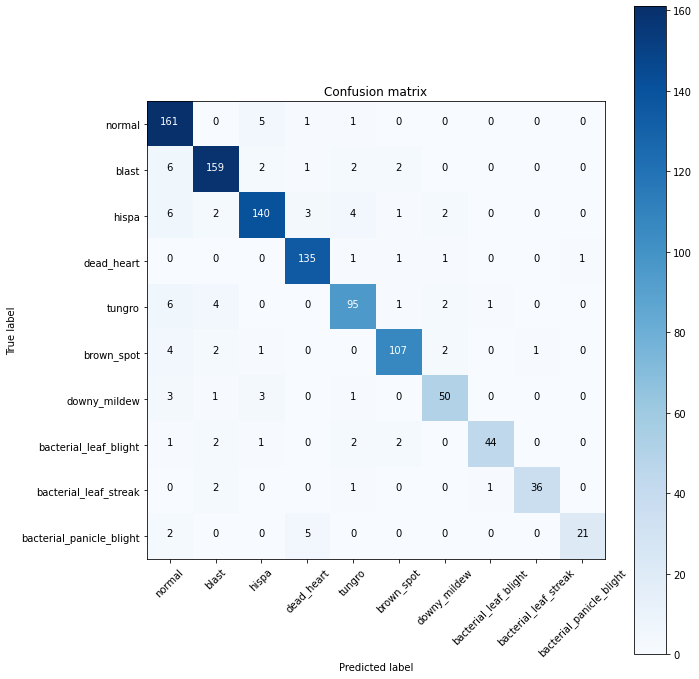

In [22]:
cnf_matrix = confusion_matrix(y_test, np.argmax(y_pred,axis = 1))
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=[                            
            'normal',
            'blast',
            'hispa',
            'dead_heart',
            'tungro',
            'brown_spot',
            'downy_mildew' ,
            'bacterial_leaf_blight' ,
            'bacterial_leaf_streak',
            'bacterial_panicle_blight'],
                      
            title='Confusion matrix')
plt.show()

In [24]:
#model.save("model_name.h5")